# A Simulation Study for Time-varying coefficients

In [1]:
import math
from math import pi
import time

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy import stats
from scipy.spatial.distance import cdist

from orbit.models.ktrx import KTRXFull, KTRXAggregated
from orbit.models.ktrlite import KTRLiteMAP
from orbit.estimators.pyro_estimator import PyroEstimatorVI, PyroEstimatorMAP
from orbit.estimators.stan_estimator import StanEstimatorMAP
from orbit.diagnostics.metrics import smape
from orbit.utils.features import make_fourier_series_df, make_fourier_series
from orbit.diagnostics.plot import plot_predicted_data

plt.style.use('fivethirtyeight')

%load_ext autoreload
%autoreload 2

# Data Simulation Modules

In [2]:
def sim_data_seasonal(n, RS):
    """ coefficients curve are sine-cosine like
    """
    np.random.seed(RS)
    # make the time varing coefs  
    tau = np.arange(1, n+1)/n
    data = pd.DataFrame({
        'tau': tau,
        'date': pd.date_range(start='1/1/2018', periods=n),
        'beta1': 2 * tau,
        'beta2': 1.01 + np.sin(2*pi*tau),
        'beta3': 1.01 + np.sin(4*pi*(tau-1/8)),
#         'x1': stats.chi2.rvs(4, size=n),
#         'x2': stats.t.rvs(2, size=n),
#         'x3': stats.t.rvs(2, size=n),
        'x1': np.random.normal(0, 10, size=n),
        'x2': np.random.normal(0, 10, size=n),
        'x3': np.random.normal(0, 10, size=n),
        'trend': np.cumsum(np.concatenate((np.array([1]), np.random.normal(0, 0.1, n-1)))),
        'error': np.random.normal(0, 1, size=n) #stats.t.rvs(30, size=n),#
    })
    
    # add error to the data 
    #err_cov = np.exp(-cdist(data.tau.values.reshape(n, -1), data.tau.values.reshape(n, -1), 'euclid')/10)
    #L = np.linalg.cholesky(err_cov).T
    #data['error2'] = L.dot(stats.chi2.rvs(100, size=n))
    
    data['y'] = data.x1 * data.beta1 + data.x2 * data.beta2 + data.x3 * data.beta3 + data.error
    #data['y2'] = data.x1 * data.beta1 + data.x2 * data.beta2 + data.x3 * data.beta3 + data.error2
    #data['y3'] = data.trend + data.x1 * data.beta1 + data.x2 * data.beta2 + data.x3 * data.beta3 + data.error
    return data

def sim_data_rw(n, RS, p=3):
    """ coefficients curve are sine-cosine like
    """
    np.random.seed(RS)

    # initializing coefficients at zeros, simulate all coefficient values
    lev = np.cumsum(np.concatenate((np.array([5.0]), np.random.normal(0, 0.01, n-1))))
    beta = np.concatenate(
        [np.random.uniform(0.05, 0.12, size=(1,p)),
         np.random.normal(0.0, 0.01, size=(n-1,p))], 
            axis=0)
    beta = np.cumsum(beta, 0)

    # simulate regressors
    covariates = np.random.normal(0, 10, (n, p))

    # observation with noise
    y = lev + (covariates * beta).sum(-1) + 0.3 * np.random.normal(0, 1, n)

    regressor_col = ['x{}'.format(pp) for pp in range(1, p+1)]
    data = pd.DataFrame(covariates, columns=regressor_col)
    beta_col = ['beta{}'.format(pp) for pp in range(1, p+1)]
    beta_data = pd.DataFrame(beta, columns=beta_col)
    data = pd.concat([data, beta_data], axis=1)
        
    data['y'] = y
    data['date'] = pd.date_range(start='1/1/2018', periods=len(y))

    return data

In [3]:
seas_data = sim_data_seasonal(n=1000, RS=8888)
seas_data.head(10)

,tau,date,beta1,beta2,beta3,x1,x2,x3,trend,error,y
0,0.001,2018-01-01,0.002,1.016283,0.010079,-4.112205,6.235252,8.318071,1.000000,-0.772024,5.640371
1,0.002,2018-01-02,0.004,1.022566,0.010316,-0.499279,-14.816010,3.641032,1.075149,1.243571,-13.871215
2,0.003,2018-01-03,0.006,1.028848,0.010711,1.826034,-2.897783,-17.144133,1.278494,-0.352154,-3.506200
3,0.004,2018-01-04,0.008,1.035130,0.011263,24.874740,5.439502,6.055187,1.104741,-0.571943,5.325848
4,0.005,2018-01-05,0.010,1.041411,0.011973,1.734577,-16.383980,9.075009,1.059079,-0.218024,-17.154473
5,0.006,2018-01-06,0.012,1.047690,0.012841,-11.059695,12.494699,2.577940,1.088198,0.541397,13.532358
6,0.007,2018-01-07,0.014,1.053968,0.013866,-6.065916,4.606459,-9.182241,1.153368,0.474600,5.117413
7,0.008,2018-01-08,0.016,1.060244,0.015049,0.945238,3.450288,13.376691,1.244678,2.122431,5.997009
8,0.009,2018-01-09,0.018,1.066519,0.016389,11.628231,11.262647,16.722551,1.167512,0.439053,12.934243
9,0.010,2018-01-10,0.020,1.072791,0.017885,2.740874,2.271040,-17.405263,1.352738,0.496264,2.676133


In [4]:
rw_data = sim_data_rw(n=300, RS=8888, p=3)
rw_data.head(10)

,x1,x2,x3,beta1,beta2,beta3,y,date
0,1.118687,12.579436,-18.705481,0.083833,0.118039,0.106882,4.238243,2018-01-01
1,0.251493,5.300673,8.974563,0.081579,0.116649,0.116075,6.762299,2018-01-02
2,-12.535904,2.134341,4.224095,0.083838,0.112736,0.121694,4.576347,2018-01-03
3,-6.830381,3.094571,-1.926185,0.067788,0.111347,0.126284,4.497561,2018-01-04
4,-3.370150,3.899625,-3.083105,0.086333,0.099882,0.138985,5.230371,2018-01-05
5,-3.364463,-4.186151,13.149254,0.076195,0.108590,0.142555,6.102766,2018-01-06
6,-3.663559,-14.795409,-1.731279,0.091534,0.099006,0.156208,3.284992,2018-01-07
7,7.205991,-5.623366,-11.806551,0.100954,0.099507,0.160083,2.529016,2018-01-08
8,-3.643661,3.799626,-1.398166,0.100640,0.087954,0.163894,4.908982,2018-01-09
9,9.222329,1.695171,-0.896493,0.098496,0.085971,0.172410,5.529784,2018-01-10


In following section, let's start with random walk type of simulation.

# Random Walk Simulation Study

## KTRLite

**KTRLite** is used to learn the trend.  We will use a default to do that.

In [5]:
p = 3

In [6]:
# define independent and response variabel
regressor_col = ['x{}'.format(pp) for pp in range(1, p + 1)]
response_col = 'y'

# run the model 
# run lite first 
ktr_lite = KTRLiteMAP(response_col=response_col,
                      date_col='date',
                      seed=2020,
                      estimator_type=StanEstimatorMAP)

ktr_lite.fit(df=rw_data)

level_knot_scale = ktr_lite.level_knot_scale
level_knots_stan = ktr_lite._aggregate_posteriors['map']['lev_knot'][0]
level_knot_dates = ktr_lite._level_knot_dates
level_knots_stan = np.array([0] * len(level_knot_dates))

## Hierarchical structure with neutral sign assumption

Each coefficient follow Normal dist. with a latent mean which also follows a Normal dist.

In [7]:
%%time
ktrx_neutral = KTRXFull(response_col=response_col,
                        date_col='date',
                        level_knot_scale=level_knot_scale,
                        level_knot_dates=level_knot_dates,
                        level_knots=level_knots_stan,
                        
                        regressor_col=regressor_col,
                        regressor_init_knot_loc=[0] * len(regressor_col),
                        regressor_init_knot_scale=[1.0] * len(regressor_col),
                        regressor_knot_scale=[0.5] * len(regressor_col),
                        
                        span_coefficients=0.1,
                        rho_coefficients=0.05,
                        prediction_percentiles=[2.5, 97.5],
                        seed=2020,
                        num_steps=501,
                        num_sample=1000,
                        learning_rate=0.2,
                        learning_rate_total_decay=0.05,
                        verbose=True,
                        message=50,
                        n_bootstrap_draws=-1,
                        estimator_type=PyroEstimatorVI,
                        
                        # new setting we want to test
                        mvn=0,
                        flat_multiplier=True,
                        geometric_walk=False,
                        min_residuals_sd=1.0)


ktrx_neutral.fit(df=rw_data)                                  

INFO:root:Guessed max_plate_nesting = 1


step    0 loss = 1332.7, scale = 0.11273
step   50 loss = 895.11, scale = 0.27829
step  100 loss = 894.93, scale = 0.27179
step  150 loss = 895.13, scale = 0.27629
step  200 loss = 894.86, scale = 0.27939
step  250 loss = 894.94, scale = 0.26851
step  300 loss = 894.16, scale = 0.27528
step  350 loss = 894.39, scale = 0.27237
step  400 loss = 894.22, scale = 0.2767
step  450 loss = 894.37, scale = 0.27562
step  500 loss = 894.11, scale = 0.2754
CPU times: user 5.97 s, sys: 291 ms, total: 6.26 s
Wall time: 5.09 s


In [8]:
idx = 3

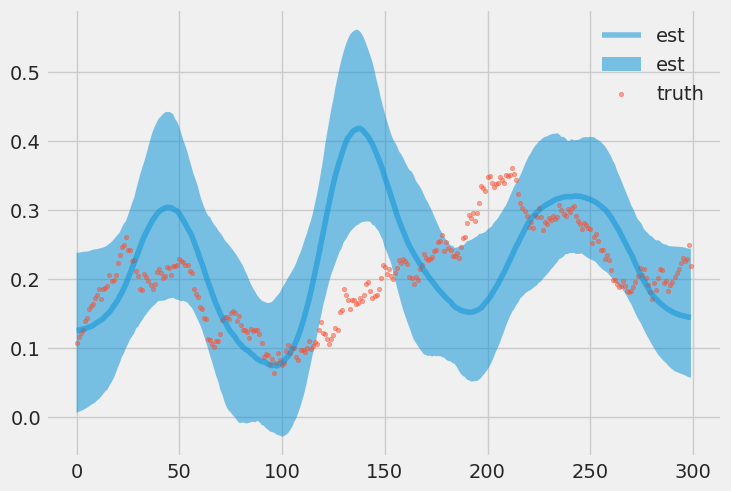

In [9]:
coef_mid, coef_lower, coef_upper  = ktrx_neutral.get_regression_coefs(include_ci=True, coefficient_method='empirical')

x = np.arange(coef_mid.shape[0])

plt.plot(x, coef_mid['x{}'.format(idx)], label='est', alpha=0.5)
plt.fill_between(x, coef_lower['x{}'.format(idx)], coef_upper['x{}'.format(idx)], label='est', alpha=0.5)
plt.scatter(x, rw_data['beta{}'.format(idx)], label='truth', s=10, alpha=0.5)
plt.legend();

/Users/zhishiw/Desktop/uTS-py/orbit/orbit/models/ktrx.py:966: UserWarning: This figure was using constrained_layout==True, but that is incompatible with subplots_adjust and or tight_layout: setting constrained_layout==False. 
  plt.tight_layout()


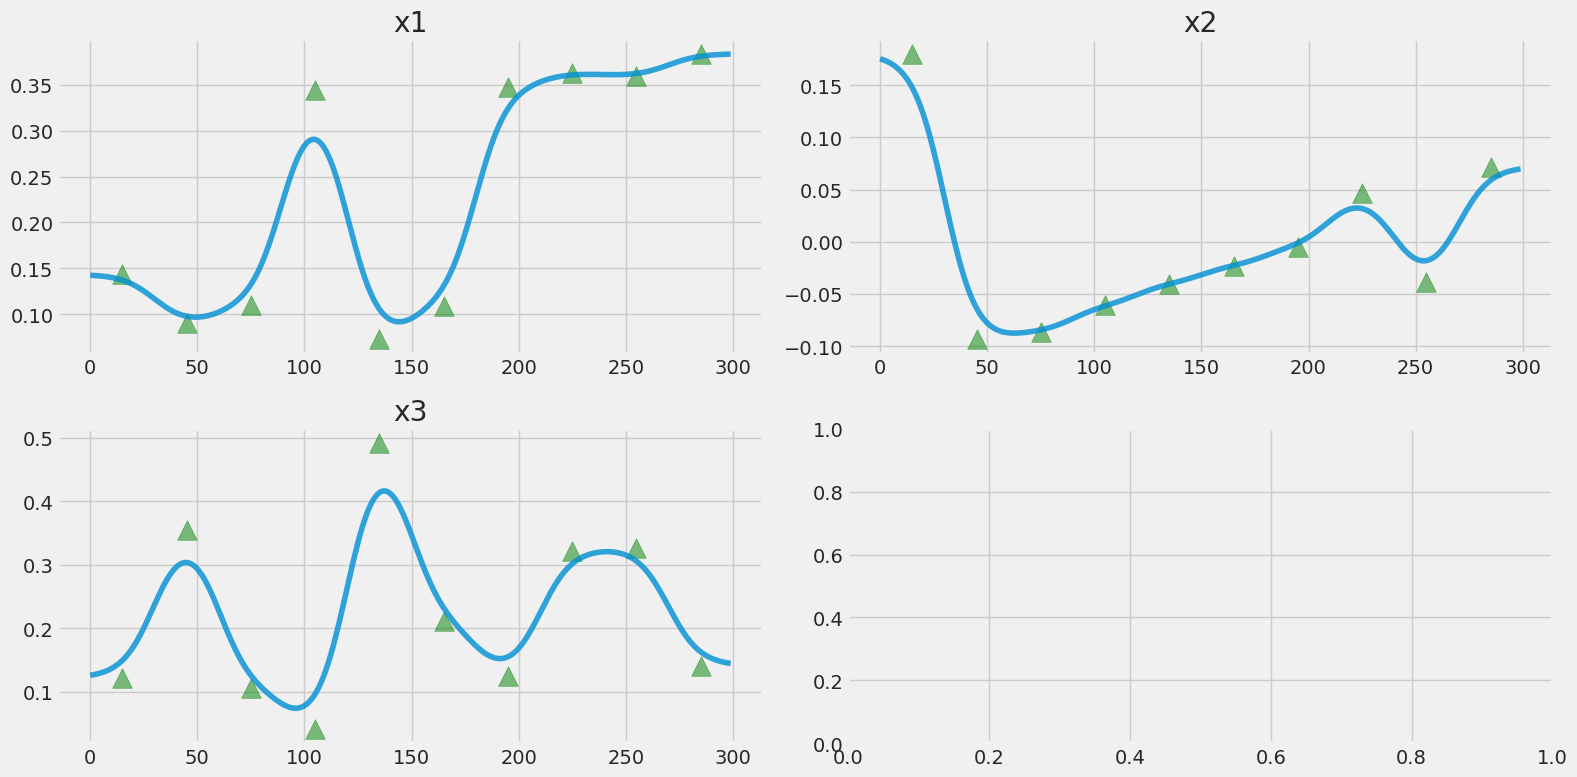

In [10]:
_ = ktrx_neutral.plot_regression_coefs(with_knot=True, figsize=(16, 8))

## Hierarchical structure with positive sign assumption

Most of setting are similar to previous setting.  However, this time we turn on sign as positive which implies all coefficient distribution are replaced by folded normal.

In [11]:
%%time
ktrx_pos = KTRXFull(response_col=response_col,
                    date_col='date',
                    level_knot_scale=level_knot_scale,
                    level_knot_dates=level_knot_dates,
                    level_knots=level_knots_stan,

                    regressor_col=regressor_col,
                    regressor_init_knot_loc=[0] * len(regressor_col),
                    regressor_init_knot_scale=[1.0] * len(regressor_col),
                    regressor_knot_scale=[0.5] * len(regressor_col),
                    # this is the only change fromp previous setting
                    regressor_sign=['+'] * len(regressor_col),

                    span_coefficients=0.1,
                    rho_coefficients=0.05, 
                    prediction_percentiles=[2.5, 97.5],
                    seed=2020,
                    num_steps=501,
                    num_sample=1000,
                    learning_rate=0.2,
                    learning_rate_total_decay=0.05,
                    verbose=True,
                    message=50,
                    n_bootstrap_draws=-1,
                    estimator_type=PyroEstimatorVI, 
    
                    # new setting we want to test
                    mvn=0,
                    flat_multiplier=True,
                    geometric_walk=False,
                    min_residuals_sd=1.0)

ktrx_pos.fit(df=rw_data)                                  

INFO:root:Guessed max_plate_nesting = 1


step    0 loss = 1756.9, scale = 0.12323
step   50 loss = 897.17, scale = 0.61133
step  100 loss = 895, scale = 0.55969
step  150 loss = 894.84, scale = 0.56168
step  200 loss = 894.52, scale = 0.55619
step  250 loss = 894.83, scale = 0.54989
step  300 loss = 894.78, scale = 0.5636
step  350 loss = 894.51, scale = 0.56171
step  400 loss = 894.31, scale = 0.55558
step  450 loss = 894.51, scale = 0.56211
step  500 loss = 893.83, scale = 0.55859
CPU times: user 6.4 s, sys: 292 ms, total: 6.69 s
Wall time: 5.54 s


In [12]:
idx = 3

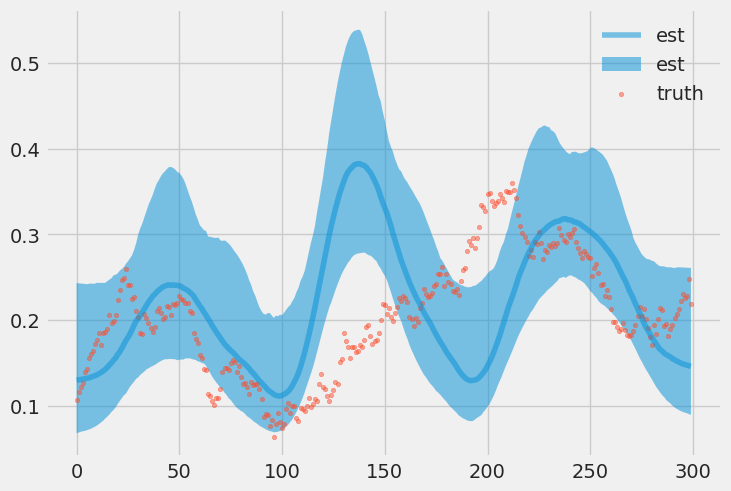

In [13]:
coef_mid, coef_lower, coef_upper  = ktrx_pos.get_regression_coefs(include_ci=True, coefficient_method='empirical')

x = np.arange(coef_mid.shape[0])

plt.plot(x, coef_mid['x{}'.format(idx)], label='est', alpha=0.5)
plt.fill_between(x, coef_lower['x{}'.format(idx)], coef_upper['x{}'.format(idx)], label='est', alpha=0.5)
plt.scatter(x, rw_data['beta{}'.format(idx)], label='truth', s=10, alpha=0.5)
plt.legend();

/Users/zhishiw/Desktop/uTS-py/orbit/orbit/models/ktrx.py:966: UserWarning: This figure was using constrained_layout==True, but that is incompatible with subplots_adjust and or tight_layout: setting constrained_layout==False. 
  plt.tight_layout()


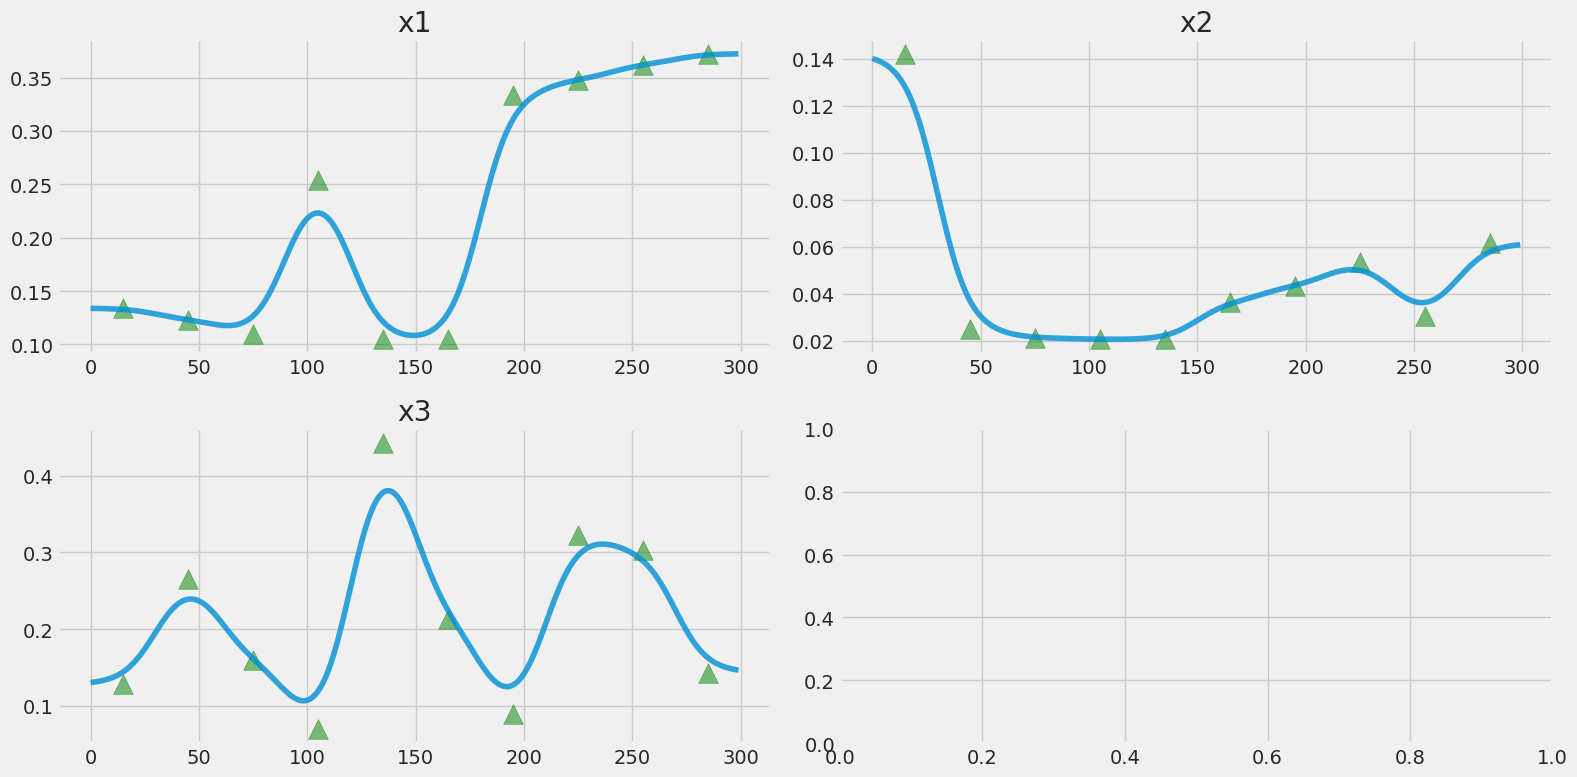

In [14]:
_ = ktrx_pos.plot_regression_coefs(with_knot=True, figsize=(16, 8))

## Gemetric random walk structure with positive sign assumption and 

Most of setting are similar to previous setting.  However, this time we turn on sign as positive which implies all coefficient distribution are replaced by folded normal.

In [15]:
%%time
ktrx_grw = KTRXFull(response_col=response_col,
                    date_col='date',
                    level_knot_scale=level_knot_scale,
                    level_knot_dates=level_knot_dates,
                    level_knots=level_knots_stan,

                    regressor_col=regressor_col,
                    regressor_init_knot_loc=[0] * len(regressor_col),
    
                    # since we turn geometric_walk to true, this setting also need to be changed from previous
                    # i.e. scale parameter is interpreted differently
                    regressor_init_knot_scale=[1.0] * len(regressor_col),
                    regressor_knot_scale=[0.5] * len(regressor_col),
                    regressor_sign=['+'] * len(regressor_col),

                    span_coefficients=0.1,
                    rho_coefficients=0.05, 
                    prediction_percentiles=[2.5, 97.5],
                    seed=2020,
                    num_steps=501,
                    num_sample=1000,
                    learning_rate=0.2,
                    learning_rate_total_decay=0.05,
                    verbose=True,
                    message=50,
                    n_bootstrap_draws=-1,
                    estimator_type=PyroEstimatorVI, 
    
                    # new setting we want to test
                    mvn=0,
                    flat_multiplier=True,
                    geometric_walk=True,
                    min_residuals_sd=1.0)

ktrx_grw.fit(df=rw_data)                                  

INFO:root:Guessed max_plate_nesting = 1


step    0 loss = 2289.3, scale = 0.10627
step   50 loss = 897.66, scale = 0.31693
step  100 loss = 885.45, scale = 0.37675
step  150 loss = 883.43, scale = 0.39381
step  200 loss = 882.05, scale = 0.3787
step  250 loss = 881.48, scale = 0.39231
step  300 loss = 880.49, scale = 0.39155
step  350 loss = 880.76, scale = 0.39687
step  400 loss = 881.58, scale = 0.39566
step  450 loss = 880.27, scale = 0.403
step  500 loss = 880.79, scale = 0.40061
CPU times: user 6.64 s, sys: 300 ms, total: 6.94 s
Wall time: 5.81 s


In [16]:
idx = 3

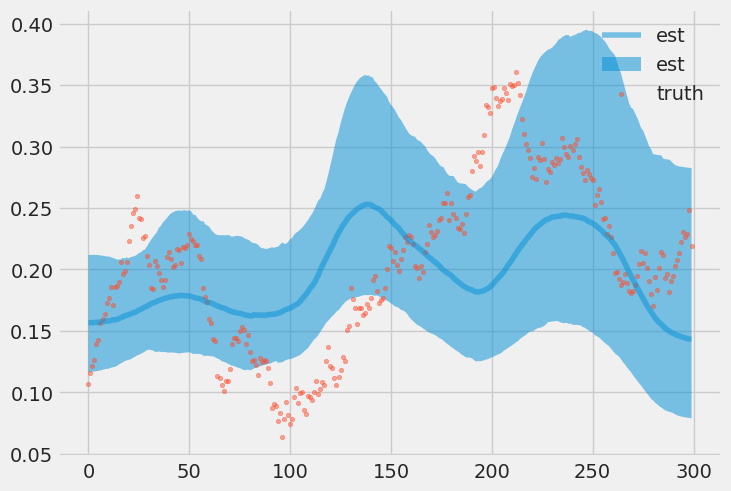

In [17]:
coef_mid, coef_lower, coef_upper  = ktrx_grw.get_regression_coefs(include_ci=True, coefficient_method='empirical')

x = np.arange(coef_mid.shape[0])

plt.plot(x, coef_mid['x{}'.format(idx)], label='est', alpha=0.5)
plt.fill_between(x, coef_lower['x{}'.format(idx)], coef_upper['x{}'.format(idx)], label='est', alpha=0.5)
plt.scatter(x, rw_data['beta{}'.format(idx)], label='truth', s=10, alpha=0.5)
plt.legend();

/Users/zhishiw/Desktop/uTS-py/orbit/orbit/models/ktrx.py:966: UserWarning: This figure was using constrained_layout==True, but that is incompatible with subplots_adjust and or tight_layout: setting constrained_layout==False. 
  plt.tight_layout()


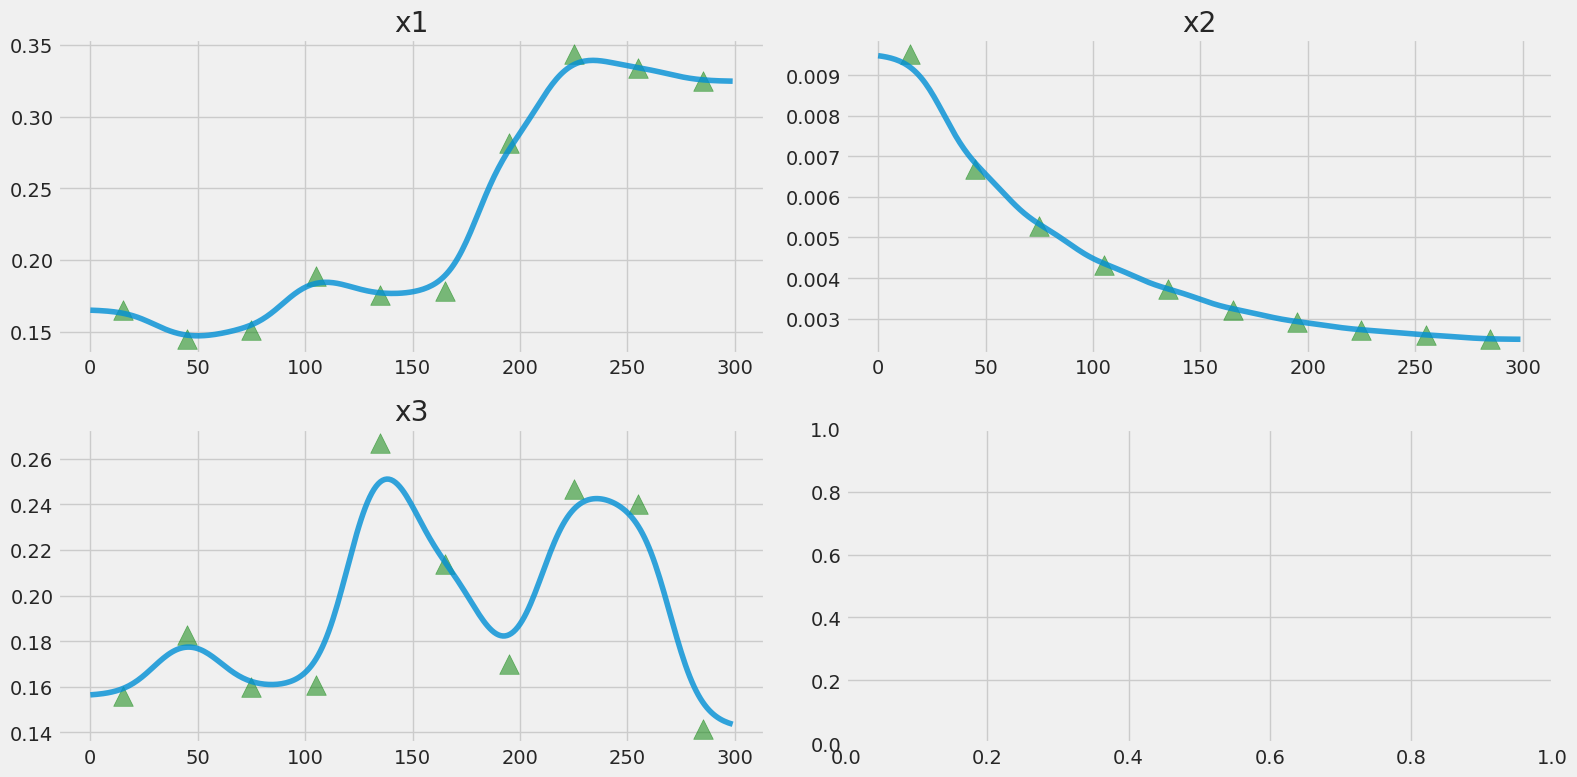

In [18]:
_ = ktrx_grw.plot_regression_coefs(with_knot=True, figsize=(16, 8))

# Sine-cosine coefficients Simulation Study

## KTRLite

**KTRLite** is used to learn the trend.  We will use a default to do that.

In [19]:
p = 3
# define independent and response variables
regressor_col = ['x{}'.format(pp) for pp in range(1, p+1)]
response_col = 'y'


# run the model 
# run lite first 
ktr_lite = KTRLiteMAP(response_col=response_col,
                      date_col='date',
                      seed=2020,
                      estimator_type=StanEstimatorMAP)

ktr_lite.fit(df=seas_data)

level_knot_scale = ktr_lite.level_knot_scale
level_knots_stan = ktr_lite._aggregate_posteriors['map']['lev_knot'][0]
level_knot_dates = ktr_lite._level_knot_dates
level_knots_stan = np.array([0] * len(level_knot_dates))

## Hierarchical structure with neutral sign assumption

Each coefficient follow Normal dist. with a latent mean which also follows a Normal dist.

In [20]:
%%time
ktrx_neutral = KTRXFull(response_col=response_col,
                        date_col='date',
                        level_knot_scale=level_knot_scale,
                        level_knot_dates=level_knot_dates,
                        level_knots=level_knots_stan,

                        regressor_col=regressor_col,
                        regressor_init_knot_loc=[0] * len(regressor_col),
                        regressor_init_knot_scale=[10.0] * len(regressor_col),
                        regressor_knot_scale=[2.0] * len(regressor_col),

                        span_coefficients=0.1,
                        rho_coefficients=0.05, 
                        prediction_percentiles=[2.5, 97.5],
                        seed=2020,
                        num_steps=501,
                        num_sample=1000,
                        learning_rate=0.2,
                        learning_rate_total_decay=0.05,
                        verbose=True,
                        message=50,
                        n_bootstrap_draws=-1,
                        estimator_type=PyroEstimatorVI, 
    
                        # new setting we want to test
                        mvn=0,
                        flat_multiplier=True,
                        geometric_walk=False,
                        min_residuals_sd=1.0)

ktrx_neutral.fit(df=seas_data)                                  

INFO:root:Guessed max_plate_nesting = 1


step    0 loss = 5457.6, scale = 0.13913
step   50 loss = 4028.3, scale = 0.40863
step  100 loss = 4025.7, scale = 0.41089
step  150 loss = 4025.8, scale = 0.41524
step  200 loss = 4025.6, scale = 0.41631
step  250 loss = 4025.7, scale = 0.40725
step  300 loss = 4025.2, scale = 0.40953
step  350 loss = 4025, scale = 0.41154
step  400 loss = 4025, scale = 0.41145
step  450 loss = 4025, scale = 0.41612
step  500 loss = 4024.9, scale = 0.41096
CPU times: user 15.4 s, sys: 2.15 s, total: 17.6 s
Wall time: 10.6 s


In [21]:
idx = 3

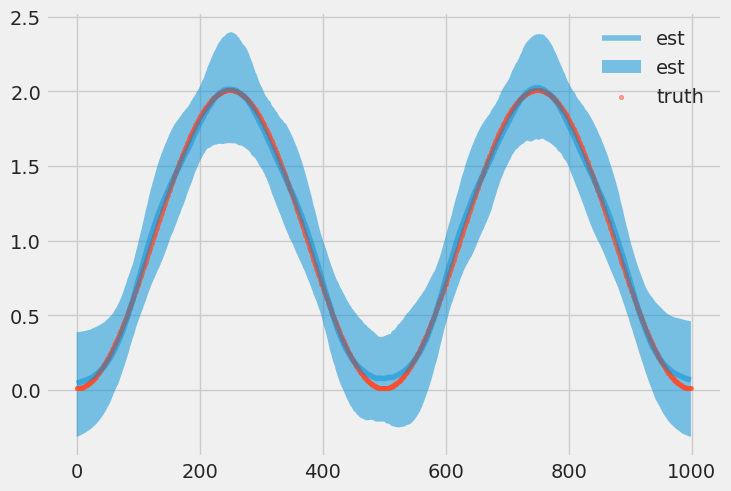

In [22]:
coef_mid, coef_lower, coef_upper  = ktrx_neutral.get_regression_coefs(include_ci=True, coefficient_method='empirical')

x = np.arange(coef_mid.shape[0])

plt.plot(x, coef_mid['x{}'.format(idx)], label='est', alpha=0.5)
plt.fill_between(x, coef_lower['x{}'.format(idx)], coef_upper['x{}'.format(idx)], label='est', alpha=0.5)
plt.scatter(x, seas_data['beta{}'.format(idx)], label='truth', s=10, alpha=0.5)
plt.legend();

/Users/zhishiw/Desktop/uTS-py/orbit/orbit/models/ktrx.py:966: UserWarning: This figure was using constrained_layout==True, but that is incompatible with subplots_adjust and or tight_layout: setting constrained_layout==False. 
  plt.tight_layout()


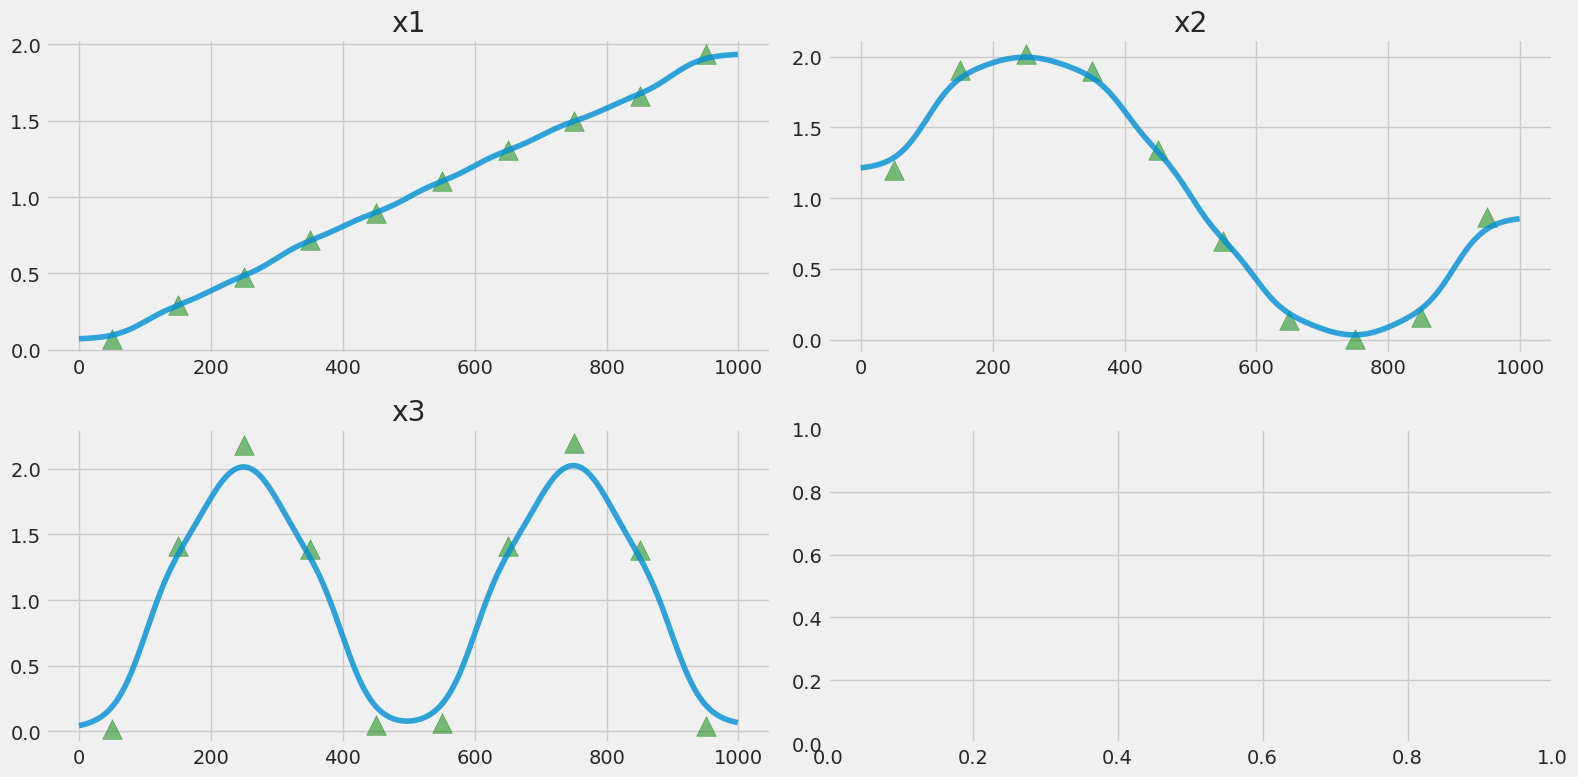

In [23]:
_ = ktrx_neutral.plot_regression_coefs(with_knot=True, figsize=(16, 8))

## Hierarchical structure with positive sign assumption

Most of setting are similar to previous setting.  However, this time we turn on sign as positive which implies all coefficient distribution are replaced by folded normal.

In [24]:
%%time
ktrx_pos = KTRXFull(response_col=response_col,
                    date_col='date',
                    level_knot_scale=level_knot_scale,
                    level_knot_dates=level_knot_dates,
                    level_knots=level_knots_stan,

                    regressor_col=regressor_col,
                    regressor_init_knot_loc=[0] * len(regressor_col),
                    regressor_init_knot_scale=[10.0] * len(regressor_col),
                    regressor_knot_scale=[2.0] * len(regressor_col),
                    # this is the only change fromp previous setting
                    regressor_sign=['+'] * len(regressor_col),

                    span_coefficients=0.1,
                    rho_coefficients=0.05, 
                    prediction_percentiles=[2.5, 97.5],
                    seed=2020,
                    num_steps=501,
                    num_sample=1000,
                    learning_rate=0.2,
                    learning_rate_total_decay=0.05,
                    verbose=True,
                    message=50,
                    n_bootstrap_draws=-1,
                    estimator_type=PyroEstimatorVI, 
    
                    # new setting we want to test
                    mvn=0,
                    flat_multiplier=True,
                    geometric_walk=False,
                    min_residuals_sd=1.0)

ktrx_pos.fit(df=seas_data)                                  

INFO:root:Guessed max_plate_nesting = 1


step    0 loss = 9449.2, scale = 0.10669
step   50 loss = 4026.2, scale = 0.48832
step  100 loss = 4016.2, scale = 0.47864
step  150 loss = 4015.8, scale = 0.48538
step  200 loss = 4015.6, scale = 0.49194
step  250 loss = 4015.8, scale = 0.48697
step  300 loss = 4015.8, scale = 0.47844
step  350 loss = 4015.2, scale = 0.48664
step  400 loss = 4015.7, scale = 0.48351
step  450 loss = 4015.4, scale = 0.49134
step  500 loss = 4015.2, scale = 0.48417
CPU times: user 15.7 s, sys: 2.13 s, total: 17.8 s
Wall time: 11.2 s


In [25]:
idx = 3

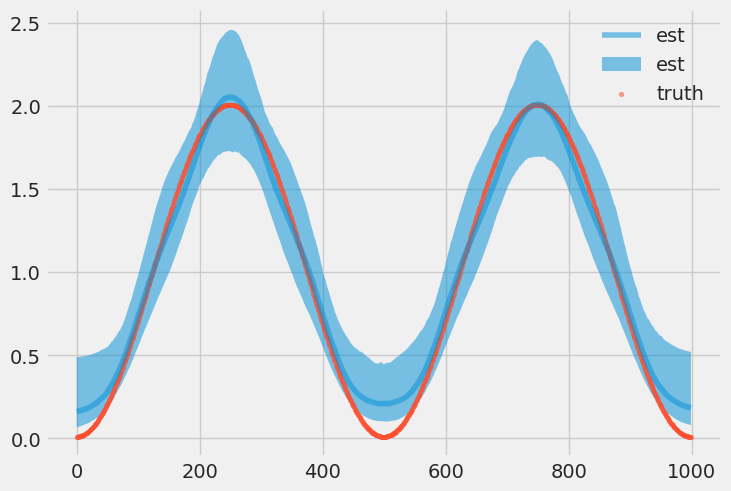

In [26]:
coef_mid, coef_lower, coef_upper  = ktrx_pos.get_regression_coefs(include_ci=True, coefficient_method='empirical')

x = np.arange(coef_mid.shape[0])

plt.plot(x, coef_mid['x{}'.format(idx)], label='est', alpha=0.5)
plt.fill_between(x, coef_lower['x{}'.format(idx)], coef_upper['x{}'.format(idx)], label='est', alpha=0.5)
plt.scatter(x, seas_data['beta{}'.format(idx)], label='truth', s=10, alpha=0.5)
plt.legend();

/Users/zhishiw/Desktop/uTS-py/orbit/orbit/models/ktrx.py:966: UserWarning: This figure was using constrained_layout==True, but that is incompatible with subplots_adjust and or tight_layout: setting constrained_layout==False. 
  plt.tight_layout()


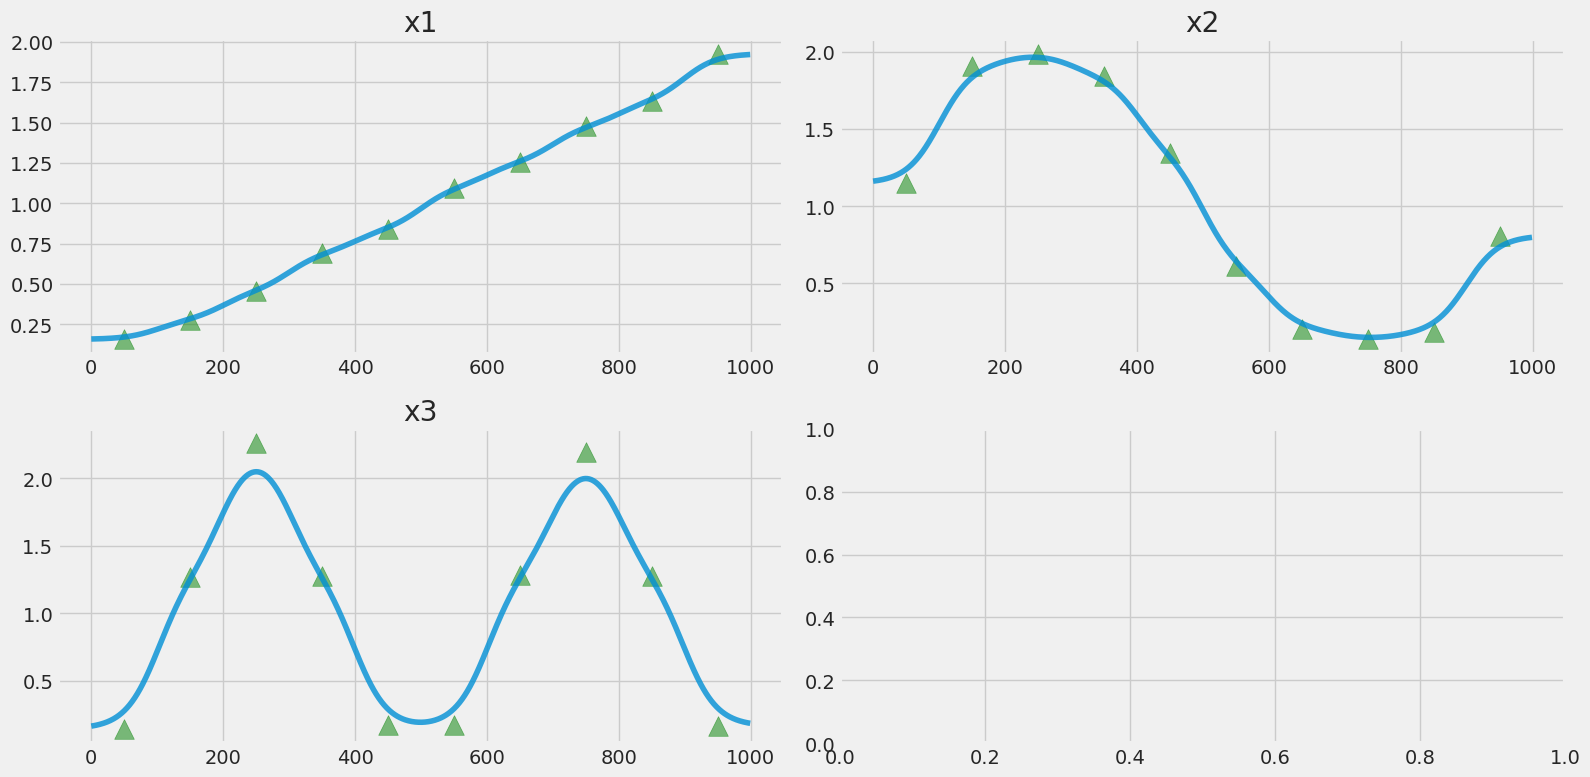

In [27]:
_ = ktrx_pos.plot_regression_coefs(with_knot=True, figsize=(16, 8))

## Gemetric random walk structure with positive sign assumption and 

Most of setting are similar to previous setting.  However, this time we turn on sign as positive which implies all coefficient distribution are replaced by folded normal.

In [28]:
%%time
ktrx_grw = KTRXFull(response_col=response_col,
                    date_col='date',
                    level_knot_scale=level_knot_scale,
                    level_knot_dates=level_knot_dates,
                    level_knots=level_knots_stan,

                    regressor_col=regressor_col,
                    regressor_init_knot_loc=[0] * len(regressor_col),
    
                    # since we turn geometric_walk to true, this setting also need to be changed from previous
                    # i.e. scale parameter is interpreted differently
                    regressor_init_knot_scale=[10.0] * len(regressor_col),
                    regressor_knot_scale=[0.2] * len(regressor_col),
                    regressor_sign=['+'] * len(regressor_col),
    
                    span_coefficients=0.1,
                    rho_coefficients=0.05, 
                    prediction_percentiles=[2.5, 97.5],
                    seed=2020,
                    num_steps=501,
                    num_sample=1000,
                    learning_rate=0.2,
                    learning_rate_total_decay=0.05,
                    verbose=True,
                    message=50,
                    n_bootstrap_draws=-1,
                    estimator_type=PyroEstimatorVI, 
    
                    # new setting we want to test
                    mvn=0,
                    flat_multiplier=True,
                    geometric_walk=True,
                    min_residuals_sd=1.0)

ktrx_grw.fit(df=seas_data)                                  

INFO:root:Guessed max_plate_nesting = 1


step    0 loss = 11049, scale = 0.10674
step   50 loss = 4080.6, scale = 0.28468
step  100 loss = 4059.7, scale = 0.29827
step  150 loss = 4053.3, scale = 0.30454
step  200 loss = 4052.7, scale = 0.31026
step  250 loss = 4051.6, scale = 0.30186
step  300 loss = 4049.3, scale = 0.30478
step  350 loss = 4050.1, scale = 0.30339
step  400 loss = 4051.6, scale = 0.30645
step  450 loss = 4049.7, scale = 0.31063
step  500 loss = 4049.1, scale = 0.30496
CPU times: user 13.5 s, sys: 1.94 s, total: 15.4 s
Wall time: 9.89 s


In [29]:
idx = 3

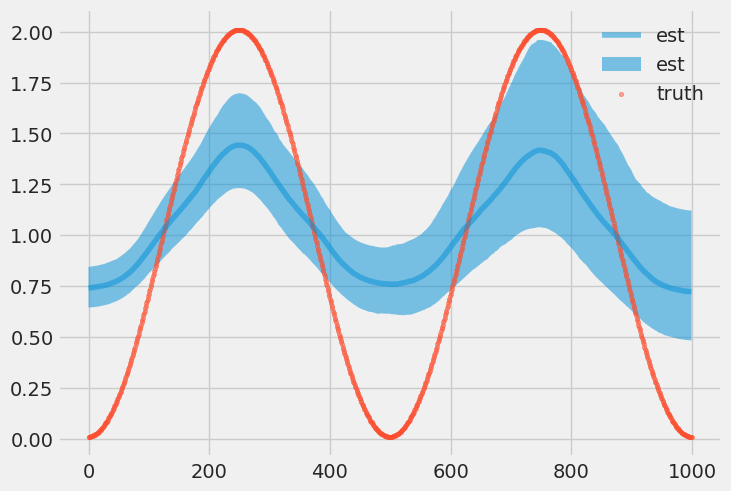

In [30]:
coef_mid, coef_lower, coef_upper  = ktrx_grw.get_regression_coefs(include_ci=True, coefficient_method='empirical')

x = np.arange(coef_mid.shape[0])

plt.plot(x, coef_mid['x{}'.format(idx)], label='est', alpha=0.5)
plt.fill_between(x, coef_lower['x{}'.format(idx)], coef_upper['x{}'.format(idx)], label='est', alpha=0.5)
plt.scatter(x, seas_data['beta{}'.format(idx)], label='truth', s=10, alpha=0.5)
plt.legend();

/Users/zhishiw/Desktop/uTS-py/orbit/orbit/models/ktrx.py:966: UserWarning: This figure was using constrained_layout==True, but that is incompatible with subplots_adjust and or tight_layout: setting constrained_layout==False. 
  plt.tight_layout()


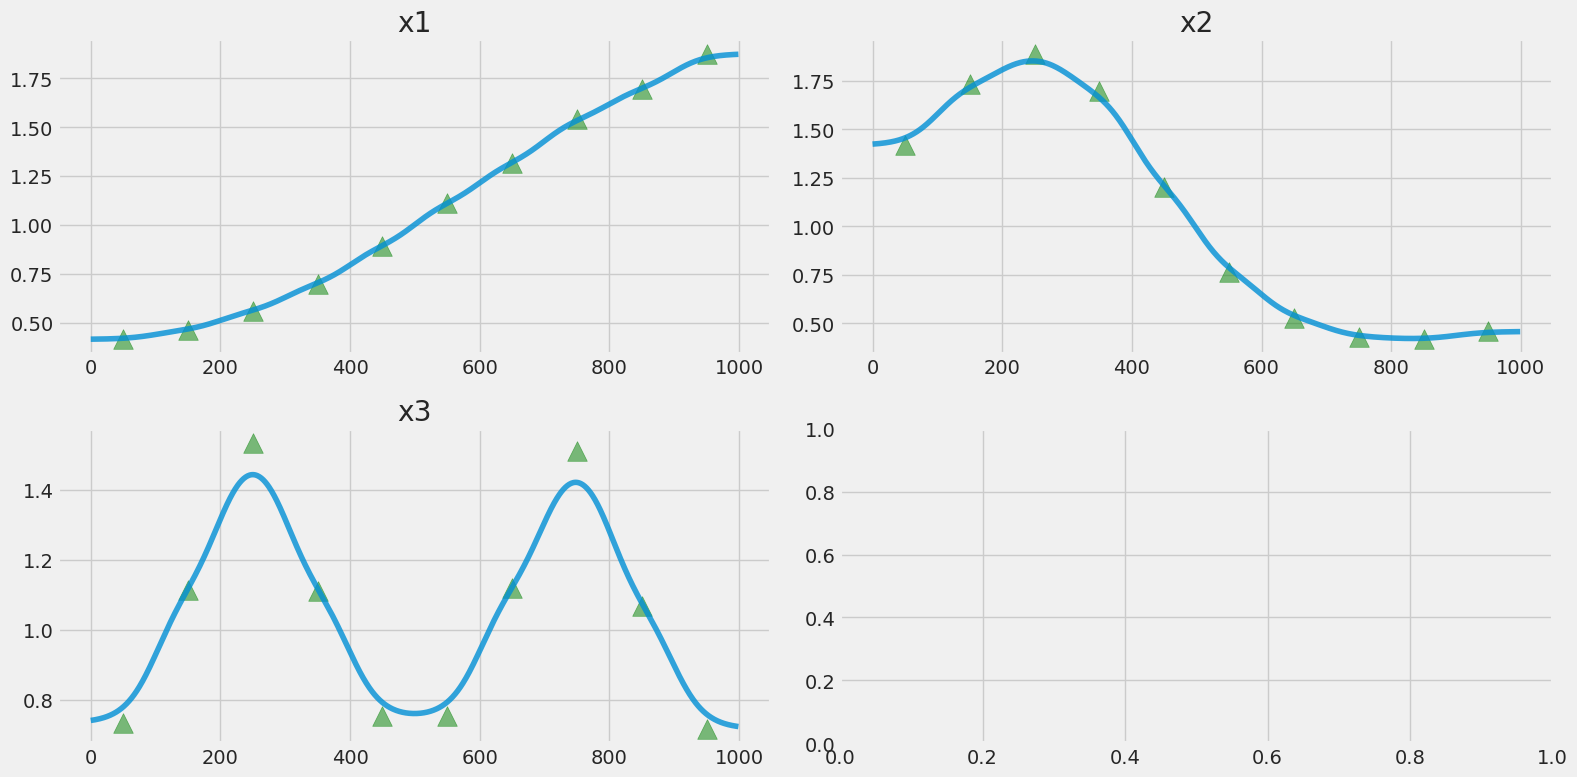

In [31]:
_ = ktrx_grw.plot_regression_coefs(with_knot=True, figsize=(16, 8))

In [32]:
# def multiple_test(N, n, sim_type):
#     out = pd.DataFrame()
#     out['index'] = range(0, N)
#     # for hte model fit 
#     out['time_1'] = 0.0
#     out['time_2'] = 0.0
    
#     out['SSE_1'] = 0.0
#     out['SSE_2'] = 0.0
#     out['RMSE_1'] = 0.0
#     out['RMSE_2'] = 0.0
#     out['max_error_1'] = 0.0
#     out['max_error_2'] = 0.0
    
#     # for the true values 
#     out['SSE_beta1_1'] = 0.0
#     out['SSE_beta1_2'] = 0.0 
#     out['SSE_beta2_1'] = 0.0   
#     out['SSE_beta2_2'] = 0.0
#     out['SSE_beta3_1'] = 0.0
#     out['SSE_beta3_2'] = 0.0

    
#     for i in range(0, N):
#         # simulate the data 
#         if sim_type == 'sea':
#             data = sim_data_seasonal(n = n, RS = 1000+i)
       
#         if sim_type == 'rw':
#             data = sim_data_rw(n = n, RS = 1000+i, p=3)    
    
#         #print(data.head())
    
#         # define stuff 
#         regressor_col=['x1', 'x2', 'x3']
#         response_col = 'y'
#         # run the model 
#         # run lite first 
#         ktr_lite = KTRLiteMAP(
#             response_col=response_col,
#             date_col='date',
#             level_knot_scale=1,
#             seed=2000+i,
#             span_level= .1, 
#             estimator_type=StanEstimatorMAP,
#         )
#         ktr_lite.fit(df=data)
#         level_knot_scale = ktr_lite.level_knot_scale
#         level_knots_stan = ktr_lite._aggregate_posteriors['map']['lev_knot'][0]
#         level_knot_dates = ktr_lite._level_knot_dates
#         level_knots_stan = np.array([0] * len(level_knot_dates))
        
#         ktrx1 = KTRXFull(
#             response_col=response_col,
#             date_col='date',

#             degree_of_freedom=30,
#             level_knot_scale=level_knot_scale,
#             level_knot_dates=level_knot_dates,
#             level_knots=level_knots_stan,

#             regressor_col=regressor_col,
#             regressor_knot_pooling_loc=[0] * len(regressor_col),
#             regressor_knot_pooling_scale=[1] * len(regressor_col),
# #             regressor_knot_scale=[1.0] * len(regressor_col),

#             span_coefficients=0.1,
#             rho_coefficients=0.1, 
#             prediction_percentiles=[2.5, 97.5],
#             seed=2000+i,
#             num_steps=1000,
#             num_sample=3000,
#             verbose=False,
#             message=100,
#             n_bootstrap_draws=-1,
#             estimator_type=PyroEstimatorVI,
#             mvn=1
#         )

#         ktrx2 = KTRXFull(
#             response_col=response_col,
#             date_col='date',

#             degree_of_freedom=30,
#             level_knot_scale=level_knot_scale,
#             level_knot_dates=level_knot_dates,
#             level_knots=level_knots_stan,

#             regressor_col=regressor_col,
#             regressor_knot_pooling_loc=[0] * len(regressor_col),
#             regressor_knot_pooling_scale=[1] * len(regressor_col),
#             regressor_knot_scale=[1.0] * len(regressor_col),

#             span_coefficients=0.1,
#             rho_coefficients=0.1, 
#             prediction_percentiles=[2.5, 97.5],
#             seed=2000+i,
#             num_steps=1000,
#             num_sample=3000,
#             verbose=False,
#             message=100,
#             n_bootstrap_draws=-1,
#             estimator_type=PyroEstimatorVI,
#         )
        
#         # fit the models and recod the times
#         start_time = time.time()
#         ktrx1.fit(df=data)
#         time_1 = time.time() - start_time
        
#         start_time = time.time()
#         ktrx2.fit(df=data)
#         time_2 = time.time() - start_time
        
#         # get the predictions 
#         predicted_df_1 = ktrx1.predict(df=data)
#         predicted_df_2 = ktrx2.predict(df=data)
            
#         # compare to observations  
#         SSE_1 = sum((predicted_df_1['prediction'] - data['y'])**2.0 )
#         SSE_2 = sum((predicted_df_2['prediction'] - data['y'])**2.0 )
        
#         max_misfit_1 = max(abs(predicted_df_1['prediction'] - data['y']) )
#         max_misfit_2 = max(abs(predicted_df_2['prediction'] - data['y']) )
    
#         out.at[i, 'time_1'] = time_1 
#         out.at[i, 'time_2'] = time_2 
    
#         out.at[i, 'SSE_1'] = SSE_1 
#         out.at[i, 'SSE_2'] = SSE_2 
        
#         out.at[i, 'RMSE_1'] = (SSE_1/n)**(0.5) 
#         out.at[i, 'RMSE_2'] = (SSE_2/n)**(0.5) 
        
        
#         out.at[i, 'max_error_1'] = max_misfit_1
#         out.at[i, 'max_error_2'] = max_misfit_2
        
#         #compare to true values 
#         coef_df_1= ktrx1.get_regression_coefs(
#         aggregate_method='median',
#         include_ci=False)
        
#         coef_df_2= ktrx2.get_regression_coefs(
#         aggregate_method='median',
#         include_ci=False)
        
#         SSE_beta1_1 = sum((coef_df_1['x1']-data['beta1'])**2.0)
#         SSE_beta2_1 = sum((coef_df_1['x2']-data['beta2'])**2.0)
#         SSE_beta3_1 = sum((coef_df_1['x3']-data['beta3'])**2.0)
#         SSE_beta1_2 = sum((coef_df_2['x1']-data['beta1'])**2.0)
#         SSE_beta2_2 = sum((coef_df_2['x2']-data['beta2'])**2.0)
#         SSE_beta3_2 = sum((coef_df_2['x3']-data['beta3'])**2.0)    
        
#         out.at[i,'SSE_beta1_1'] = SSE_beta1_1
#         out.at[i,'SSE_beta2_1'] = SSE_beta2_1
#         out.at[i,'SSE_beta3_1'] = SSE_beta3_1
#         out.at[i,'SSE_beta1_2'] = SSE_beta1_2
#         out.at[i,'SSE_beta2_2'] = SSE_beta2_2
#         out.at[i,'SSE_beta3_2'] = SSE_beta3_2
        
#     return out


In [33]:
# out = multiple_test(N=2, n=300, sim_type='sea')

In [34]:
# multiple_test(N=3, n=300, sim_type='rw')